# Basic DNN tutorial using Keras+TF on the MNIST dataset

In [1]:
import numpy as np

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,11) # Defines the size of the images for display only

C:\Users\darenas\AppData\Local\Continuum\anaconda3\envs\condaPy3TFKe\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First things first, lets load the data we are going to use.
Fortunately, Keras propose some functions to retreive some popular datasets (generally used for testing and learning). More information here ([Keras datasets](https://keras.io/datasets/)).
The MNIST training dataset containns 60K 28x28pixel images, each one containing a single digit (between 0 to 9). For a comprehensive description of the dataset go to ([MNIST](http://yann.lecun.com/exdb/mnist/)).
The following lines of code will load the data and show its size.

In [2]:
# the data, shuffled and split between tran and test sets
(X_trainFull, y_trainFull), (X_test_o, y_test_o) = mnist.load_data()
print("X_train original shape", X_trainFull.shape)
print("y_train original shape", y_trainFull.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Since the original MNIST dataset does not contain a validation set, we are going to create one by randomly selecting 10K images from the training dataset. Therefore, we will have the following sets to work with:
* Training set (50K images): for training the model
* Validation set (10K images): for validate the model, perform adjustements
* Test set (10K images): for evaluating the moded using data that wasnt used during training, tuning and validation 

In [3]:
indices = np.random.permutation(60000)
training_idx, validation_idx = indices[:50000], indices[50000:]
X_train_o, X_val_o = X_trainFull[training_idx,:], X_trainFull[validation_idx,:]
y_train_o, y_val_o = y_trainFull[training_idx,], y_trainFull[validation_idx,]

print("X_train shape", X_train_o.shape)
print("X_validate shape", X_val_o.shape)
print("X_test shape", X_test_o.shape)

X_train shape (50000, 28, 28)
X_validate shape (10000, 28, 28)
X_test shape (10000, 28, 28)


We know that we have 10 classes for this dataset (digits between 0 to 9) but lets verify this by checking how many different labels are on ***y_train***.

In [4]:
nb_classes = 10

if nb_classes == len(np.unique(y_train_o)) :
    print("Correct! There are indeed 10 unique labels on y_train")
else:
    print("Something is wrong, the nb_classes does not correspond to the number of unique labes on y_train")

Correct! There are indeed 10 unique labels on y_train


Let's see now some of the data, the next lines of code will display 9 consecutive images of the training dataset. Feel free to modify the ***initIdx*** (remember to keep it within 0 and 49991)

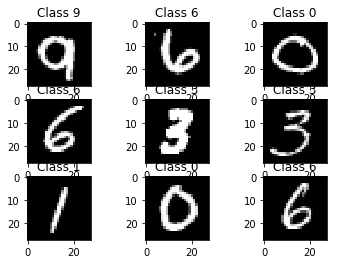

In [10]:
initIdx = 100
someRange = np.add(list(range(9)), initIdx)
for i in someRange:
    plt.subplot(3,3,i-initIdx+1)
    plt.imshow(X_train_o[i], cmap='gray')
    plt.title("Class {}".format(y_train_o[i]))

The architecture of the Neural Networ we are going to build in this example is described in the followinf figure. It taks as input the entire image (i.e., the matrix of 28x28 pixels). Next, three fully connected layers containing 128 neurons each and finally an output layer containing 10 neurons, one neuron for each class (digits 0 to 9).
<img src="images/figure2.png">

For convenience the input matrix will be flatten in a one dimentional vector of 28x28 = 784 elements.
Neural networks work typically better with normalized data, so instead of having input values ranging from 0 to 255, we are going to normalize these values between 0 and 1 (by dividing each value by 255).

In [11]:
X_train = X_train_o.reshape(50000, 784)
X_val = X_val_o.reshape(10000, 784)
X_test = X_test_o.reshape(10000, 784)
X_train = np.array(X_train, dtype='float32')
X_val = np.array(X_val, dtype='float32')
X_test = np.array(X_test, dtype='float32')
X_train /= 255
X_val /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (50000, 784)
Validation matrix shape (10000, 784)
Testing matrix shape (10000, 784)


To match the size of the output of the neural network (which can be seen as a vector or 10 elements ranging from 0 to 1) we are going to transform the labels using the one-hot format. This means:<br>
0 becomes the vector \[1, 0, 0, 0, 0, 0, 0, 0, 0, 0\]<br>
1 becomes the vector \[0, 1, 0, 0, 0, 0, 0, 0, 0, 0\]<br>
2 becomes the vector \[0, 0, 1, 0, 0, 0, 0, 0, 0, 0\]<br>
3 becomes the vector \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\]<br>
...<br>
Feel free to change the ***idx*** to check other values

In [12]:
y_train = np_utils.to_categorical(y_train_o, nb_classes)
y_val = np_utils.to_categorical(y_val_o, nb_classes)
y_test = np_utils.to_categorical(y_test_o, nb_classes)
idx = 1500
print("Original Y[%d] = %d, its corresponding one-hot representation = %s"%(idx, y_train_o[idx], str(y_train[idx]) ) )

Original Y[1500] = 3, its corresponding one-hot representation = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


The following lines of code will create the neural network wich will be stored on the variable ***model***. This simple deep neural network architecture is composed of 4 layers:<br>
* one imput layer of 784 neurons (each one corresponding to a pixel on the image)
* three hidden fully connected layer of 128 neurons each (the activation function\* chosen is the REctified Linear Unit RELU followed by a dropout regularization\* to reduce overfitting)
* one output layer of 10 neurons activated by a softmax function (which means that the sum of all values of the outputs is 1)

\* other activation functions and regularization methods can be used, for an introduction check [activation functions](https://en.wikipedia.org/wiki/Activation_function) and [regularization](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/)

In [13]:
model = Sequential()
model.add(Dense(128, input_shape=(784,)))
model.add(Activation('relu'))                           
model.add(Dropout(0.25))   
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(10))
model.add(Activation('softmax'))

Python is an excellent choice for fast prototyping and developping, but it lacks the power to efficiently run the multiple complex mathematical operations on the CPU/GPU required to train a neural network. By using Keras library, which in turn relies on Tensorflow (or Theano), we are able to design the architecture of the neural network without worrying about the actual implementation of the computation graph. It is in this graph where the actual calculations take place, by calling the  ***compile*** function this computation graph is generated according to the model we defined. For this example, we are using the [Adam](https://keras.io/optimizers/) optimizer and the [Accuracy](https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9) as a measure or quality. 

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Once generated, this computation graph is ready to perform training (or predictions), note that these libraries will produce a highly optimized graph for the current system (e.g., single CPU or multiple GPUs). We then begin the raining by invoking the ***fit*** function. Note that all 60K images of the training set will be used for training 4 times (number of ***epochs***). Moreover, since matrix multiplication is the main operation behind neural networks and these are highly parallelisable, neural networks are able to process several input images at the same time (***batch_size***), feel free to modify this value. 

In [15]:
model.fit(X_train, y_train,
          epochs=4,
          batch_size=256, 
          verbose=1,
          validation_data=(X_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 3s 57us/step - loss: 0.6521 - acc: 0.7914 - val_loss: 0.2207 - val_acc: 0.9331
Epoch 2/4
50000/50000 [==============================] - 2s 45us/step - loss: 0.2512 - acc: 0.9258 - val_loss: 0.1504 - val_acc: 0.9535
Epoch 3/4
50000/50000 [==============================] - 2s 44us/step - loss: 0.1903 - acc: 0.9437 - val_loss: 0.1281 - val_acc: 0.9621
Epoch 4/4
50000/50000 [==============================] - 3s 51us/step - loss: 0.1580 - acc: 0.9531 - val_loss: 0.1143 - val_acc: 0.9629


The training accuracy should be close to 97% while the validation accuracy whould be close to 98%. This means that in average, the network is able to correctly recognise a digit 97-98% of the time. At this point, we would normally perform [Hyperparameter Tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) by using the validation set as a benchmark. However, since our algorithm performs so well we are going to use the test set to measure its *real* accuracy. 

In [16]:
score = model.evaluate(X_test, y_test,
                       verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 49us/step
Test score: 0.10770013553272001
Test accuracy: 0.9664


We can see that the accuracy on the test set is similar to the one obtained on the validation set (around 98%), this means our algorithm is not overfitting our trainning/validation data and maintains its mean accuracy.<br>
It is not perfect hoever, some images are not correctly classified, lets see which images are correctly classified and which are not.

In [17]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test_o)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test_o)[0]

First, the following code will show a group of correctly classified images from the test set

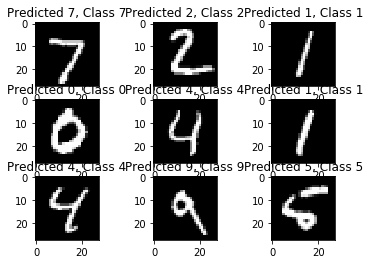

In [18]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test_o[correct]))

Next, some images that are incorrectly classified

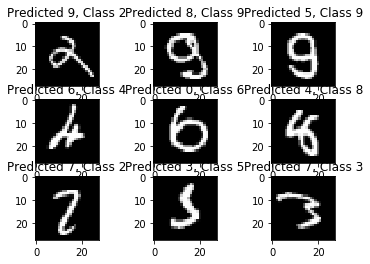

In [19]:
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test_o[incorrect]))

In [20]:
#TODO: show the confusion matrix